<a href="https://colab.research.google.com/github/dbonafilia/SGDWR-AdamWR-Keras/blob/master/Main_Training_Stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
LR = 5e-4
EPOCHS = 1000
EPOCHS_PER_UPDATE = 1
RUNNAME = "5e4_handlabeled_0"

In [6]:
cd /home

/home


In [7]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
import random

class InMemoryDataset(torch.utils.data.Dataset):
  
  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func
  
  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])
  
  def __len__(self):
    return len(self.data_list)


def processAndAugment(data):
  (x,y) = data
  im,label = x.copy(), y.copy()

  # convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  label = Image.fromarray(label.squeeze())

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))
  
  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)
  if random.random() > 0.5:
    im1 = F.hflip(im1)
    im2 = F.hflip(im2)
    label = F.hflip(label)
  if random.random() > 0.5:
    im1 = F.vflip(im1)
    im2 = F.vflip(im2)
    label = F.vflip(label)
  
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()])
  im = norm(im)
  label = transforms.ToTensor()(label).squeeze()
  if torch.sum(label.gt(.003) * label.lt(.004)):
    label *= 255
  label = label.round()

  return im, label


def processTestIm(data):
  (x,y) = data
  im,label = x.copy(), y.copy()
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  #label[0][0][0] = 255
  # convert to PIL for easier transforms
  im_c1 = Image.fromarray(im[0]).resize((512,512))
  im_c2 = Image.fromarray(im[1]).resize((512,512))
  label = Image.fromarray(label.squeeze()).resize((512,512))

  im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
  im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
            F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]


  ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                    transforms.ToTensor()(y).squeeze()))
                    for (x,y) in zip(im_c1s, im_c2s)]
  ims = [norm(im) for im in ims]
  ims = torch.stack(ims)
  labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
  labels = torch.stack(labels)
  if torch.sum(labels.gt(.003) * labels.lt(.004)):
    labels *= 255
  labels = labels.round()
  return ims, labels


Read in Data

In [8]:
!pip install rasterio

In [9]:
import csv
from PIL import Image
import rasterio
import numpy as np
import os
BASEDIR = 'files3/'

def getArr(fname):
  return rasterio.open(BASEDIR + fname).read()


def download_perm_water_data_from_file(fname):
  with open(fname) as f:
    data_fnames = [tuple(line) for line in csv.reader(f)]
  i = 0
  data = []
  for (x,y) in data_fnames:
    arr_x, arr_y = getArr(os.path.join("S1Perm", x)), getArr(os.path.join("PermJRC", y))
    if np.sum((arr_x != arr_x)) == 0:
      ignore = (arr_y == -1)
      ignore = ((np.uint8(ignore) * -1) * 256) + 1
      arr_y *= ignore
      data.append((arr_x, arr_y))
      i+=1
      print(i)
    else:
      print("skipping nan")
  return data

def download_perm_train_data():
  TRAINING_DATA_FILE = BASEDIR + 'permanent_water_train_data.csv'
  return download_perm_water_data_from_file(TRAINING_DATA_FILE)

def download_perm_valid_data():
  VALID_DATA_FILE = BASEDIR + 'permanent_water_validation_data.csv'
  return download_perm_water_data_from_file(VALID_DATA_FILE)

def download_perm_test_data():
  TEST_DATA_FILE = BASEDIR + 'permanent_water_test_data.csv'
  return download_perm_water_data_from_file(TEST_DATA_FILE)


In [10]:
from time import time

def getArrFlood(fname):
  return rasterio.open(fname).read()

def download_flood_water_data_from_list(l):
  print("WHYYYYY")
  i= 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (im_fname, mask_fname) in l:
    if not os.path.exists(os.path.join("files3/", im_fname)):
      print(os.path.join("files3/", im_fname))
      continue
    arr_x = np.nan_to_num(getArrFlood(os.path.join("files3/", im_fname)))
    arr_y = getArrFlood(os.path.join("files3/", mask_fname))
    ignore = (arr_y == -1)
    ignore = ((np.uint8(ignore) * -1) * 256) + 1
    arr_y *= ignore
    arr_y = np.uint8(getArrFlood(os.path.join("files3/", mask_fname)))
    if np.sum((arr_y != arr_y)) == 0:
      arr_x = np.clip(arr_x, -50, 1)
      arr_x = (arr_x + 50) / 51
      if i % 100 == 0:
        print(i)
        print(im_fname, mask_fname)
      i += 1
      flood_data.append((arr_x,arr_y))
    else:
      print("skipping nan")
  print(i)
  return flood_data


def load_flood_train_data():
  basedir = "files4/"
  fname = "files3/flood_train_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  return download_flood_water_data_from_list(fname)

def load_weak_flood_train_data():
  basedir = "files4/"
  files = [(os.path.join("S1_NoQC", x[1]), os.path.join("NoQC", x[0])) for x in zip(sorted(os.listdir("files3/NoQC")), sorted(os.listdir("files3/S1_NoQC")))]
  files = [x for x in files if "Bolivia" not in x[0]]
  print(files[0:10])
  return download_flood_water_data_from_list(files)

def load_weak_flood_S1_train_data():
  basedir = "files4/"
  files = [(os.path.join("S1_NoQC", x[1]), os.path.join("S1Flood_NoQC", x[0])) for x in zip(sorted(os.listdir("files3/S1Flood_NoQC")), sorted(os.listdir("files3/S1_NoQC")))]
  print(files[0:10])
  return download_flood_water_data_from_list(files)

def load_flood_valid_data():
  basedir = "files4/"
  fname = "files3/flood_valid_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  print(fname, "files!")
  return download_flood_water_data_from_list(fname)

def load_flood_test_data():
  basedir = "files4/"
  fname = "files3/flood_test_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  return download_flood_water_data_from_list(fname)

def load_flood_bolivia_test_data():
  basedir = "files4/"
  fname = "files3/flood_bolivia_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  return download_flood_water_data_from_list(fname)




In [11]:
train_data = load_flood_train_data()#load_weak_flood_S1_train_data()
train_dataset = InMemoryDataset(train_data, processAndAugment)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
train_iter = iter(train_loader)

WHYYYYY
0
S1/Ghana_103272_S1.tif QC_v2/Ghana_103272_QC.tif
100
S1/Pakistan_132143_S1.tif QC_v2/Pakistan_132143_QC.tif
200
S1/Sri-Lanka_916628_S1.tif QC_v2/Sri-Lanka_916628_QC.tif
252


In [12]:
valid_data = load_flood_valid_data() #download_perm_valid_data()
valid_dataset = InMemoryDataset(valid_data, processTestIm)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
valid_iter = iter(valid_loader)

[('S1/Ghana_5079_S1.tif', 'QC_v2/Ghana_5079_QC.tif'), ('S1/Ghana_895194_S1.tif', 'QC_v2/Ghana_895194_QC.tif'), ('S1/Ghana_868803_S1.tif', 'QC_v2/Ghana_868803_QC.tif'), ('S1/Ghana_142312_S1.tif', 'QC_v2/Ghana_142312_QC.tif'), ('S1/Ghana_234935_S1.tif', 'QC_v2/Ghana_234935_QC.tif'), ('S1/Ghana_132163_S1.tif', 'QC_v2/Ghana_132163_QC.tif'), ('S1/Ghana_495107_S1.tif', 'QC_v2/Ghana_495107_QC.tif'), ('S1/Ghana_124834_S1.tif', 'QC_v2/Ghana_124834_QC.tif'), ('S1/Ghana_1033830_S1.tif', 'QC_v2/Ghana_1033830_QC.tif'), ('S1/Ghana_277_S1.tif', 'QC_v2/Ghana_277_QC.tif'), ('S1/Ghana_308249_S1.tif', 'QC_v2/Ghana_308249_QC.tif'), ('S1/India_1050276_S1.tif', 'QC_v2/India_1050276_QC.tif'), ('S1/India_764946_S1.tif', 'QC_v2/India_764946_QC.tif'), ('S1/India_118868_S1.tif', 'QC_v2/India_118868_QC.tif'), ('S1/India_533192_S1.tif', 'QC_v2/India_533192_QC.tif'), ('S1/India_180633_S1.tif', 'QC_v2/India_180633_QC.tif'), ('S1/India_244057_S1.tif', 'QC_v2/India_244057_QC.tif'), ('S1/India_691027_S1.tif', 'QC_v2/In

Set up net/parameters

In [13]:
import torchvision.models as models
import torch.nn as nn

net = models.segmentation.fcn_resnet50(pretrained=False, num_classes=2, pretrained_backbone=False)
net.backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,8]).float().cuda(), ignore_index=255) # 
#criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.AdamW(net.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(train_loader) * 10, T_mult=2, eta_min=0, last_epoch=-1)
def convertBNtoGN(module, num_groups=16):
  if isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d):
    return nn.GroupNorm(num_groups, module.num_features,
                        eps=module.eps, affine=module.affine)
    if module.affine:
        mod.weight.data = module.weight.data.clone().detach()
        mod.bias.data = module.bias.data.clone().detach()

  for name, child in module.named_children():
      module.add_module(name, convertBNtoGN(child, num_groups=num_groups))

  return module

net = convertBNtoGN(net)
net

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): GroupNorm(16, 64, eps=1e-05, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): GroupNorm(16, 256, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): GroupNorm(16, 256, eps=1e-05, affine=True)
        )
  

Utility Functions

In [14]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  iou = (intersection + .0000001) / (union + .0000001)
  if iou != iou:
    print("failed, replacing with 0")
    iou = torch.tensor(0).float()
  return iou
  

def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))
  return correct.float() / len(target)


In [15]:
test_1 = torch.ones(2, 2, 256, 256)
test_2 = torch.zeros(2, 256, 256)
test_3 = torch.ones(2, 256, 256)


print(computeIOU(test_1.cuda(), test_2.cuda()))
print(computeIOU(test_1.cuda(), test_3.cuda()))

tensor(7.6294e-13, device='cuda:0')
tensor(1., device='cuda:0')


Train/Validation functions

In [16]:

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

def train(inputs, labels, net, optimizer, scheduler):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  # zero the parameter gradients
  optimizer.zero_grad()
  net = net.cuda()
  # forward + backward + optimize
  outputs = net(inputs.cuda())
  loss = criterion(outputs["out"], labels.long().cuda())
  loss.backward()
  optimizer.step()
  scheduler.step()

  running_loss += loss
  running_iou += computeIOU(outputs["out"], labels.cuda())
  running_accuracy += computeAccuracy(outputs["out"], labels.cuda())
  running_count += 1

def validation_loop(validation_data_loader, net):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global max_valid_iou

  global training_losses
  global training_accuracies
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious

  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          net = net.cuda()
          outputs = net(images.cuda())
          valid_loss = criterion(outputs["out"], labels.long().cuda())
          valid_iou = computeIOU(outputs["out"], labels.cuda())
          valid_accuracy = computeAccuracy(outputs["out"], labels.cuda())
          iou += valid_iou
          loss += valid_loss
          accuracy += valid_accuracy
          count += 1

  iou = iou / count
  accuracy = accuracy / count

  if iou > max_valid_iou:
    max_valid_iou = iou
    save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    torch.save(net.state_dict(), save_path)
    print("model saved at", save_path)

  loss = loss / count
  print("Training Loss:", running_loss / running_count)
  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation Loss:", loss)
  print("Validation IOU:", iou)
  print("Validation Accuracy:", accuracy)


  training_losses.append(running_loss / running_count)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_losses.append(loss)
  valid_accuracies.append(accuracy)
  valid_ious.append(iou)


In [17]:
def test_loop(test_data_loader, net):
  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in tqdm(test_data_loader):
          net = net.cuda()
          outputs = net(images.cuda())
          valid_loss = criterion(outputs["out"], labels.long().cuda())
          valid_iou = computeIOU(outputs["out"], labels.cuda())
          iou += valid_iou
          accuracy += computeAccuracy(outputs["out"], labels.cuda())
          count += 1

  iou = iou / count
  print("Test IOU:", iou)
  print("Test Accuracy:", accuracy / count)


Train Loop

In [18]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train(inputs.cuda(), labels.cuda(), net.cuda(), optimizer, scheduler)
 

def train_validation_loop(net, optimizer, scheduler, train_loader,
                          valid_loader, num_epochs, cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  net = net.train()
  running_loss = 0
  running_iou = 0
  running_count = 0
  running_accuracy = 0
  for i in tqdm(range(num_epochs)):
    train_iter = iter(train_loader)
    train_epoch(net, optimizer, scheduler, train_iter)
  clear_output()
  print("Current Epoch:", cur_epoch)
  validation_loop(iter(valid_loader), net)

test_loader[0] == usa_loader[0]

Current Epoch: 0
model saved at checkpoints/5e4_handlabeled_0_0_0.1470426768064499.cp
Training Loss: tensor(0.7198, device='cuda:0', grad_fn=<DivBackward0>)
Training IOU: tensor(0.1032, device='cuda:0')
Training Accuracy: tensor(0.4429, device='cuda:0')
Validation Loss: tensor(0.6704, device='cuda:0')
Validation IOU: tensor(0.1470, device='cuda:0')
Validation Accuracy: tensor(0.4021, device='cuda:0')


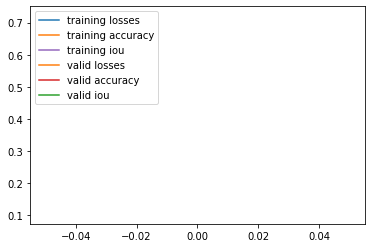

None

max valid iou: tensor(0.1470, device='cuda:0')


In [ ]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 0

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []



for i in range(start, 1000):
  train_validation_loop(net, optimizer, scheduler, train_loader, valid_loader, 10, i)
  epochs.append(i)
  x = epochs
  plt.plot(x, training_losses, label='training losses')
  plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
  plt.plot(x, training_ious, 'tab:purple', label='training iou')
  plt.plot(x, valid_losses, label='valid losses')
  plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
  plt.plot(x, valid_ious, 'tab:green',label='valid iou')
  plt.legend(loc="upper left")

  display(plt.show())

  print("max valid iou:", max_valid_iou)
  #test_loop(test_loader, net)
  #test_loop(bolivia_loader, net)

